In [2]:
import cv2
import numpy as np
import pandas as pd
import statistics
import torch
import os
import time
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import torchvision.transforms as tf
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from PIL import Image
from collections import OrderedDict
import seaborn as sns

torch.cuda.empty_cache()


In [3]:
modelA = torch.load('MODELS/modelA_bw_2cats_float_balanced_resnet18_withTL.pth',map_location=torch.device('cuda'))
modelB = torch.load('MODELS/modelB_bw-float_balanced_resnet18_wTL.pth',map_location=torch.device('cuda'))

In [4]:
print(modelA)
print(modelB)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
#full_sample = cv2.imread('../Machine Learning_GARTH/Garth_base_oriented.jpg')
#full_sample = cv2.cvtColor(full_sample,cv2.COLOR_BGR2RGB)

Image.MAX_IMAGE_PIXELS = None

sample = 'Garth_base_oriented'
zoom=1

full_sample = np.array(Image.open(f'../Machine Learning_GARTH/201012_jpgs/{sample}/{sample}.jpg').getchannel('G'))


trans = tf.Compose([tf.Resize((256,256),interpolation=5),
                  tf.ToTensor(),
                   ])

In [6]:
#Slice the Image


In [7]:
pixels_per_image = 256

h_in = int(pixels_per_image/zoom)
w_in = h_in

h = full_sample.shape[0]
w = full_sample.shape[1]

n_h = h//h_in
n_w = w//w_in

r_h = h%h_in
r_w = w%w_in

print(f'height: {h} pixels,width: {w} pixels')
print(f'images in height: {n_h},images in width: {n_w}')
print(f'lost pixels in height: {r_h}, lost pixels in width: {r_w}')

full_sample = full_sample[int(r_h/2):(h-int(r_h/2)),int(r_w/2):(w-int(r_w/2))]

sample_length = 24251
um_per_pixel_w = sample_length/w
um_per_image_w = um_per_pixel_w * pixels_per_image
image_beginning = np.array([i*um_per_image_w for i in range(n_w)])
print(image_beginning)
image_end = image_beginning + um_per_image_w
print(image_end)

height: 3994 pixels,width: 39022 pixels
images in height: 15,images in width: 152
lost pixels in height: 154, lost pixels in width: 110
[    0.           159.09630465   318.1926093    477.28891395
   636.38521859   795.48152324   954.57782789  1113.67413254
  1272.77043719  1431.86674184  1590.96304649  1750.05935114
  1909.15565578  2068.25196043  2227.34826508  2386.44456973
  2545.54087438  2704.63717903  2863.73348368  3022.82978832
  3181.92609297  3341.02239762  3500.11870227  3659.21500692
  3818.31131157  3977.40761622  4136.50392087  4295.60022551
  4454.69653016  4613.79283481  4772.88913946  4931.98544411
  5091.08174876  5250.17805341  5409.27435805  5568.3706627
  5727.46696735  5886.563272    6045.65957665  6204.7558813
  6363.85218595  6522.9484906   6682.04479524  6841.14109989
  7000.23740454  7159.33370919  7318.43001384  7477.52631849
  7636.62262314  7795.71892778  7954.81523243  8113.91153708
  8273.00784173  8432.10414638  8591.20045103  8750.29675568
  8909.39306

In [8]:
#Feed in the image and collect results

In [9]:
cutoff = 0.7

quality_matrix = np.zeros((n_h,n_w), dtype = float) 
layer_matrix = np.zeros((n_h,n_w), dtype = float)


w_point = 0
start_time = time.time()

for j in range(n_w):
    if j%int(n_w/10) ==0:
        print(f'{j//int(n_w/10)*10:.0F}%')
    h_point = 0
    for i in range(n_h):        
        active_image = full_sample[h_point:h_point+h_in,w_point:w_point+w_in]
        active_image = Image.fromarray(active_image)
        
        h_point+=h_in
        
        quality_matrix[i,j] =  modelA(trans(active_image).view(1,1,256,256).cuda()).item()
        
        if quality_matrix[i,j]>=cutoff:
            layer_matrix[i,j] =  modelB(trans(active_image).view(1,1,256,256).cuda()).item()
            
    w_point+=w_in

print(time.time()-start_time)
        
        

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
53.81122660636902


In [10]:
active_image.size

(256, 256)

In [11]:
quality_matrix[quality_matrix<0] = 0
quality_matrix[quality_matrix>1] = 1
quality_matrix

array([[0.71584123, 0.73911041, 1.        , ..., 0.00634056, 0.00164893,
        0.0036584 ],
       [0.03946753, 0.01063753, 0.04003759, ..., 0.0069068 , 0.00292851,
        0.00506721],
       [0.        , 0.        , 0.        , ..., 0.00591367, 0.00326616,
        0.00444414],
       ...,
       [0.00774001, 0.00998173, 0.00608942, ..., 0.        , 0.00679939,
        0.00341276],
       [0.00953445, 0.0091185 , 0.00628184, ..., 0.        , 0.0021252 ,
        0.00628895],
       [0.00877034, 0.00748404, 0.01054997, ..., 0.        , 0.        ,
        0.00319365]])

In [12]:
layer_matrix

array([[2.69242668, 3.5149951 , 3.06791472, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [13]:
#save model

tosave = pd.DataFrame(quality_matrix)
tosave.head()
tosave.to_csv(f'{sample}_qm_float.csv',index=False, header=True)

tosave = pd.DataFrame(layer_matrix)
tosave.head()
tosave.to_csv(f'{sample}_lm_float.csv',index=False, header=True)

In [14]:
#load model

toload=pd.read_csv(f'{sample}_{zoom}_qm_float.csv')
quality_matrix = toload.to_numpy()


toload=pd.read_csv(f'{sample}_{zoom}_lm_float.csv')
layer_matrix = toload.to_numpy()


In [15]:
full_sample_quality_density_bin = np.zeros((full_sample.shape[0],full_sample.shape[1]), dtype = float)
full_sample_layer_density_bin = np.zeros((full_sample.shape[0],full_sample.shape[1]), dtype = float)
full_sample_cutoff_bin = full_sample.copy()

for j in range(full_sample.shape[1]-1):
    for i in range(full_sample.shape[0]):
        full_sample_quality_density_bin[i,j]=quality_matrix[i//h_in,j//w_in]
        full_sample_layer_density_bin[i,j]=layer_matrix[i//h_in,j//w_in]
        if quality_matrix[i//h_in,j//w_in] <cutoff:
            full_sample_cutoff_bin[i,j]= 0 
        
        
        
    if j%int(full_sample.shape[1]/10)==0:
        print(f'{j/int(full_sample.shape[1])*100:.0F}%')

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [16]:
#Uncertainty - Monte Carlo

In [17]:
carlo = []
num_sim = 10000
for i in range(num_sim):
    
    if i%int((num_sim-1)/10)==0:
        print(f'{i/(num_sim-1)*100:.0F}%')
    
    carlo_count = 0
    for j in range(layer_matrix.shape[1]):
        popul = layer_matrix[:,j][layer_matrix[:,j]!=0]
        try:
            carlo_count += np.random.choice(popul,1,replace=False)
        except:
            pass
    carlo.append(carlo_count.item())

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%


In [18]:
#growth rate distribution at each x - position

In [19]:
layer_reduced=[]
sd=[]
sem=[]
avg=[]
n=[]
sd_umperlayer=[]
sem_umperlayer=[]
missing_len=0
missing_tot=0

for j in range(layer_matrix.shape[1]-1):
    

    popul = layer_matrix[:,j][layer_matrix[:,j]!=0]
   # try: 
    layer_reduced.append(popul)
    if popul.size == 0:
        missing_len+=1
        sd.append(0)
        sem.append(0)
        avg.append(0)
        n.append(0)
        sd_umperlayer.append(0)
        sem_umperlayer.append(0)
    else:
        missing_tot+=popul.size
    

        sd.append(np.std(popul))       
        avg.append(np.mean(popul))
        n.append(popul.size)
        sem.append(np.std(popul)/np.sqrt(popul.size))
        sd_umperlayer.append(np.std(um_per_image_w/popul))     
        sem_umperlayer.append(np.std(um_per_image_w/popul)/np.sqrt(popul.size))





sd.append(0)
sem.append(0)
avg.append(0)
n.append(0)
sd_umperlayer.append(0)
sem_umperlayer.append(0)
    
missing_len = missing_len/n_w*100
missing_tot = missing_tot/(n_w*n_h)*100

percent_length_counted = 100-missing_len
percent_total_counted = 100-missing_tot


print(f'Of the total length, {percent_length_counted:.1F} % were counted. \nOf all images submitted, {percent_total_counted:.1F} % were classified')

Of the total length, 80.3 % were counted. 
Of all images submitted, 73.0 % were classified


In [20]:
len(sd)

152

In [21]:
output_file = pd.DataFrame()

In [22]:
output_file['from_px']=[i*pixels_per_image for i in range(0,n_w)]
output_file['to_px']=output_file['from_px']+pixels_per_image-1

output_file['from_um']=image_beginning
output_file['to_um']=image_end

output_file['countable_imgs']=n


output_file['avg']=avg

output_file['sd']=sd
output_file['sd_umperlayer']=sd_umperlayer
output_file['sem']=sem
output_file['sem_umperlayer']=sem_umperlayer


output_file['umperlayer']= np.divide((output_file['to_um']-output_file['from_um']),
                                     output_file['avg'],out=np.zeros_like(output_file['avg']),where=output_file['countable_imgs']!=0)


#np.divide(a, b, out=np.zeros_like(a), where=b!=0)



In [23]:
# stamp = time.strftime("%Y%m%d%H%M%S", time.gmtime())
# output_file.to_csv(f'data_{sample}_{stamp}.csv')
# print(n_h,n_w)
# full_sample_density_bin = np.zeros((n_h,n_w), dtype = float)
# full_sample_density_bin.shape[0]
# output_file.tail()

15 152


,from_px,to_px,from_um,to_um,countable_imgs,avg,sd,sd_umperlayer,sem,sem_umperlayer,umperlayer
147,37632,37887,23387.156783,23546.253088,1,5.778341,0.0,0.0,0.0,0.0,27.533214
148,37888,38143,23546.253088,23705.349393,0,0.000000,0.0,0.0,0.0,0.0,0.000000
149,38144,38399,23705.349393,23864.445697,0,0.000000,0.0,0.0,0.0,0.0,0.000000
150,38400,38655,23864.445697,24023.542002,0,0.000000,0.0,0.0,0.0,0.0,0.000000
151,38656,38911,24023.542002,24182.638307,0,0.000000,0.0,0.0,0.0,0.0,0.000000


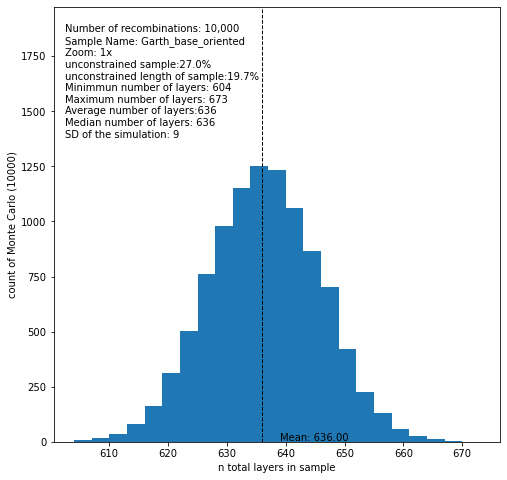

In [24]:
minimum_carlo = round(min(carlo))
maximum_carlo = round(max(carlo))
avg_carlo = round(statistics.mean(carlo))
med_carlo = round(statistics.median(carlo))
sd_carlo=round(statistics.stdev(carlo))
stepsize_carlo = int((maximum_carlo-minimum_carlo)/20)


fig,(ax1) = plt.subplots(nrows=1,ncols=1, sharex=False)
fig.set_figheight(8)
fig.set_figwidth(8)

ax1.hist(carlo,bins=(range(minimum_carlo,maximum_carlo+stepsize_carlo,stepsize_carlo)))
ax1.axvline(avg_carlo, color='k', linestyle='dashed', linewidth=1)
ax1.text(avg_carlo+stepsize_carlo, stepsize_carlo, 'Mean: {:.2f}'.format(avg_carlo))

ax1.set_xlabel('n total layers in sample')
ax1.set_ylabel('count of Monte Carlo (10000)')
ylim=ax1.get_ylim()[1]*1.5
ax1.set_ylim(0,ylim)

ax1.text(minimum_carlo-stepsize_carlo/2,ylim*0.70,f'''Number of recombinations: 10,000
Sample Name: {sample}
Zoom: {zoom}x
unconstrained sample:{missing_tot:.1F}%
unconstrained length of sample:{missing_len:.1F}%
Minimmun number of layers: {minimum_carlo}
Maximum number of layers: {maximum_carlo}
Average number of layers:{avg_carlo}
Median number of layers: {med_carlo}
SD of the simulation: {sd_carlo}''')




stamp = time.strftime("%Y%m%d%H%M%S", time.gmtime())

plt.savefig('monte_carlo_{}_{}_{}.png'.format(sample, zoom, str(stamp)))

plt.show()

In [25]:
#potentially temporary solution for graphing

pixel=[]
avg=[]
sd=[]
sem=[]
n=[]
umperlayer=[]
sd_umperlayer=[]
sem_umperlayer=[]

for _,i in output_file.iterrows():
    pixel_temp=[]
    avg_temp=[]
    sd_temp=[]
    sem_temp=[]
    n_temp=[]
    umperlayer_temp=[]
    sd_umperlayer_temp=[]
    sem_umperlayer_temp=[]
    
    for j in range(int(i['from_px']),int(i['to_px'])):
        pixel_temp.append(j)
        avg_temp.append(i['avg'])
        sd_temp.append(i['sd'])
        sem_temp.append(i['sem'])
        n_temp.append(i['countable_imgs'])
        umperlayer_temp.append(i['umperlayer'])
        sd_umperlayer_temp.append(i['sd_umperlayer'])
        sem_umperlayer_temp.append(i['sem_umperlayer'])
        
        
        
    pixel.extend(pixel_temp)
    avg.extend(avg_temp)
    sd.extend(sd_temp)
    sem.extend(sem_temp)
    n.extend(n_temp)
    umperlayer.extend(umperlayer_temp)
    sd_umperlayer.extend(sd_umperlayer_temp)
    sem_umperlayer.extend(sem_umperlayer_temp)

output_file_pixel=pd.DataFrame()

output_file_pixel['px']=pixel
output_file_pixel['countable_imgs']=n

output_file_pixel['avg']=avg

output_file_pixel['sd']=sd

output_file_pixel['sem']=sem
output_file_pixel['umperlayer']=umperlayer
output_file_pixel['sd_umperlayer']=sd_umperlayer
output_file_pixel['sem_umperlayer']=sem_umperlayer




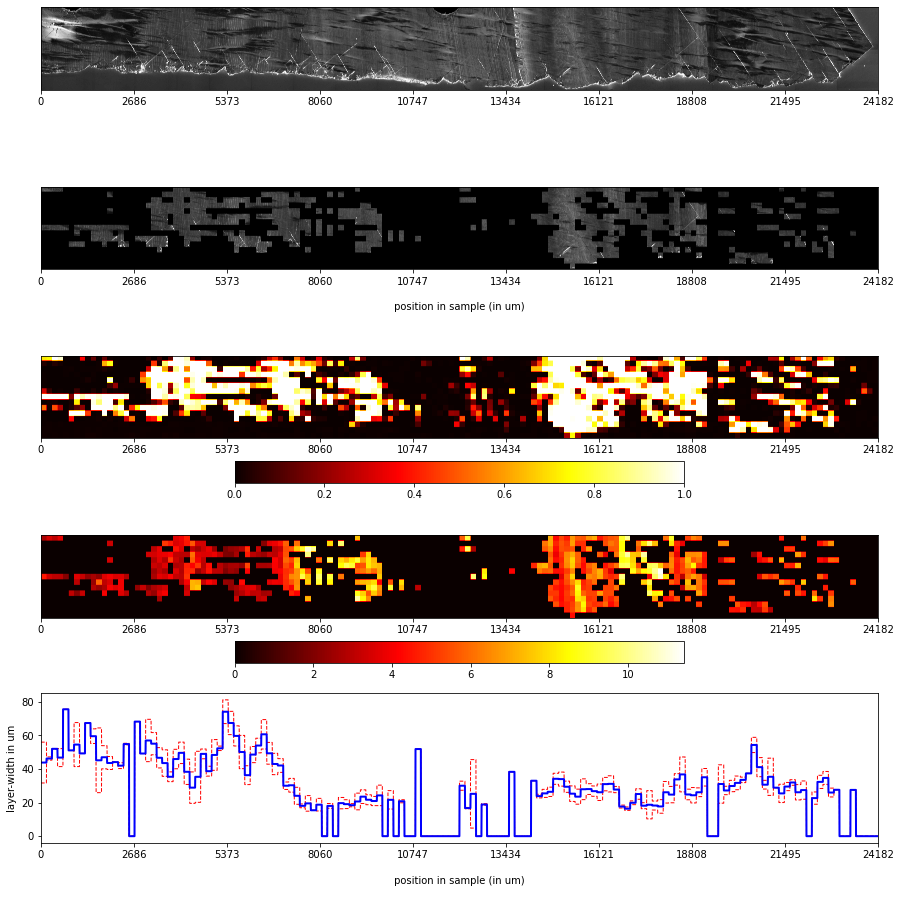

In [26]:
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=5,ncols=1, sharex=False)


#ax1.set_xticklabels()
fig.set_figheight(16)
fig.set_figwidth(15)


ax1.imshow(full_sample, cmap='gray')
ax1.set_yticks([])
ax1.set_xticks(np.round(np.linspace(0,full_sample.shape[1],10)))
ax1.set_xticklabels(np.linspace(0,um_per_pixel_w*full_sample.shape[1],10,dtype=int))


flm = ax2.imshow(full_sample_cutoff_bin,cmap='gray')
#fig.colorbar(flm, ax = ax2, orientation='horizontal')
ax2.set_xticks(np.round(np.linspace(0,full_sample.shape[1],10)))
ax2.set_xticklabels(np.linspace(0,um_per_pixel_w*full_sample.shape[1],10,dtype=int))
ax2.set_xlabel('\n position in sample (in um) \n \n')
ax2.set_yticks([])



qm = ax3.imshow(full_sample_quality_density_bin,cmap='hot')
ax3.set_xticks(np.round(np.linspace(0,full_sample.shape[1],10)))
ax3.set_xticklabels(np.linspace(0,um_per_pixel_w*full_sample.shape[1],10,dtype=int))
ax3.set_xlabel('\n position in sample (in um) \n \n')
ax3.set_yticks([])
fig.colorbar(qm, ax = ax3, orientation='horizontal')


lm = ax4.imshow(full_sample_layer_density_bin,cmap='hot')
ax4.set_xticks(np.round(np.linspace(0,full_sample.shape[1],10)))
ax4.set_xticklabels(np.linspace(0,um_per_pixel_w*full_sample.shape[1],10,dtype=int))
ax4.set_xlabel('\n position in sample (in um) \n \n')
ax4.set_yticks([])
fig.colorbar(lm, ax = ax4, orientation='horizontal')


ax5.plot( output_file_pixel['px'], output_file_pixel['umperlayer']+output_file_pixel['sd_umperlayer'],marker='', scalex = 0, markerfacecolor='red', markersize=12, color='red', linewidth=1,linestyle='--'  )
ax5.plot( output_file_pixel['px'], (output_file_pixel['umperlayer']-output_file_pixel['sd_umperlayer']), marker='', scalex = 0, markerfacecolor='red', markersize=12, color='red', linewidth=1,linestyle='--'  )
ax5.plot( 'px', 'umperlayer', data=output_file_pixel,marker='', scalex = 0, markerfacecolor='blue', markersize=12, color='blue', linewidth=2)



ax5.set_xticks(np.round(np.linspace(0,full_sample.shape[1],10)))
ax5.set_xticklabels(np.linspace(0,um_per_pixel_w*full_sample.shape[1],10,dtype=int))
ax5.set_xlabel('\n position in sample (in um) \n \n')
ax5.set_ylabel('layer-width in um')


stamp = time.strftime("%Y%m%d%H%M%S", time.gmtime())
plt.savefig('sample_layerDensity_{}_{}_{}.png'.format(sample,zoom, str(stamp)))

In [27]:
# #Click-Functionality

# pt1 = (0,0)
# pt2 = (0,0)

# click1 = False
# click2 = False

# pt3 = (0,0)
# pt4 = (0,0)

# click3 = False
# click4 = False

# zoom_frame = cv2.resize(full_sample.copy(),dsize=(int(full_sample.shape[1]/40),int(full_sample.shape[0]/40)))
            

# def zoomer(event,x,y,flags,param):

#     global pt1,pt2,click1,click2
    
#     if event == cv2.EVENT_LBUTTONDOWN:

#         if click1 == True and click2 == True:
#             click1 = False
#             click2 = False
#             pt1 = (0,0)
#             pt2 = (0,0)
            
#         elif click1 == False:
#             pt1 = (x,y)
#             click1 = True
            
#         elif click2 == False:
#             pt2 = (x,y)
#             click2 = True
            
    
#     return None

# def calc_layers(event,x,y,flags,param):
    
#     global pt3,pt4,click3,click4
    
#     if event == cv2.EVENT_LBUTTONDOWN:
    
#         if click3 == True and click4 == True:
#             click3 = False
#             click4 = False
#             pt3 = (0,0)
#             pt4 = (0,0)

#         elif click3 == False:
#             pt3 = (x,y)
#             click3 = True
            
#         elif click4 == False:
#             pt4 = (x,y)
#             click4 = True
        
        
    
#     return None


# cv2.namedWindow('sample')


# # Bind draw_rectangle function to mouse clicks
# cv2.setMouseCallback('sample', zoomer) 

# frame= cv2.resize(full_sample.copy(),dsize=(int(full_sample.shape[1]/40),int(full_sample.shape[0]/40)))

# while True:
    
#     if not click1 and not click2: 
#         frame= cv2.resize(full_sample.copy(),dsize=(int(full_sample.shape[1]/40),int(full_sample.shape[0]/40)))

    
#     if click1 and not click2: 
#         cv2.circle(frame, center=pt1, radius=4, color=(0,0,255), thickness=-1)
    
#     cv2.imshow('sample', frame)
       
#     #drawing rectangle
#     if click1 and click2:
#         cv2.rectangle(frame, pt1, pt2, (0, 0, 255), 2)
#         cv2.imshow('sample', frame)

#      #   cv2.namedWindow('Zoom')
#      #   cv2.setMouseCallback('Zoom', calc_layers) 

        
#         top_left=(40*min(pt1[0],pt2[0]),40*min(pt1[1],pt2[1]))
#         bottom_right=(40*max(pt1[0],pt2[0]),40*max(pt1[1],pt2[1]))
#       #  top_right=(bottom_right[0],top_left[1])
#       #  bottom_left=(bottom_right[1],top_left[0])
       
#         zoom_frame= full_sample.copy()[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]]
#         zoom_layers=full_sample_density_bin.copy()
#         zoom_layers=zoom_layers[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]]/h_in

#         while True:
        
#             cv2.setMouseCallback('Zoom', calc_layers) 
           
#             if not click3 and not click4: 
#                 zoom_frame= full_sample.copy()[top_left[1]:bottom_right[1],top_left[0]:bottom_right[0]]
                
        
#             if click3 and not click4: 
#                 cv2.circle(zoom_frame, center=pt3, radius=4, color=(255,0,0), thickness=-1)
    
            
#             if click3 and click4:
                       
#                 cv2.line(zoom_frame, pt3,pt4, (255, 0, 0), 1)
#                 cv2.arrowedLine(zoom_frame, pt4, (pt4[0],pt3[1]), (255, 0, 0), 1)
#                 cv2.line(zoom_frame, pt3, (pt4[0],pt3[1]), (0, 0, 255), 2)              
#                 cv2.namedWindow('Zoom')
                
#                 zoom_sum=zoom_layers[pt3[1],pt3[0]:pt4[0]].sum()
#                 cv2.putText(zoom_frame,str(int(round(zoom_sum,0))),pt3,cv2.FONT_HERSHEY_PLAIN,2,(255,255,255))
 
#             cv2.imshow('Zoom',zoom_frame)

#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 click1 = False
#                 click2 = False
#                 click3 = False
#                 click4 = False
#                 cv2.destroyWindow('Zoom') 
#                 cv2.setMouseCallback('sample', zoomer) 
#                 break

          
            
        
#     # Display the resulting frame

#     # This command let's us quit with the "q" button on a keyboard.
#     # Simply pressing X on the window won't work!
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# # When everything is done, release the capture
# cv2.destroyAllWindows()

In [28]:
# cv2.destroyAllWindows()